Load V1 receptive fields from Ringach et. al. and compute covariance matrix

In [100]:
import numpy as np
import numpy.linalg as la
import glob
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from estimator import V1_inspired_weights, V1_inspired_weights_same_center
import h5py

In [101]:
dataroot = 'data/V1_data_Ringach/'
data = sio.loadmat(dataroot + 'rf_db.mat')['rf']
num_cells, dim = 250, 32 ** 2 # 250 cells with RF of size 32 x 32

In [102]:
# different cells have difference receptive field sizes (32 x 32, 64 x 64, 128 x 128). 
# Downsample them all to be 32 x 32.
STA = np.zeros((num_cells, dim))
time_to_peak = np.zeros(num_cells)
d2p = np.zeros(num_cells)

for cell in range(num_cells):
    s = data[0][cell][0]
    resize_factor = int(s.shape[0] / 32)
    s_scaled = downscale_local_mean(s, (resize_factor, resize_factor))
    STA[cell] = s_scaled.flatten()
    time_to_peak[cell] = data[0][cell][1]
    d2p[cell] = data[0][cell][2]

For both model and data, compute the covariance matrix along with the eigenvectors and eigenvalues

In [103]:
# pre-processing; z-score all the receptive fields
STA = (STA - np.mean(STA, axis=1).reshape(-1, 1)) / np.std(STA, axis=1).reshape(-1, 1)

# generate receptive field from our random feature model
W = V1_inspired_weights(num_cells, dim, t=2,l=1.5, scale=1, random_state=None)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)

# covariance matrices
C_data = STA.T @ STA
C_data *= dim / np.trace(C_data).reshape(-1, 1)

C_model = W.T @ W
C_model *= dim / np.trace(C_model).reshape(-1, 1)

# spectra analyses
eigval_data, eigvec_data = la.eigh(C_data)
eigval_model, eigvec_model = la.eigh(C_model)

In [ ]:
# plot a few receptive fields
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Example receptive fields (top, data), (bottom, model)', y=1)
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(num_cells)
    plt.imshow(STA[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.imshow(W[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
# plt.savefig('results/ringach_data/receptive_fields.pdf')

Visualize the covariance matrices and plot the eigenalue spectrum

In [ ]:
clim = 3
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(132)
plt.title('Covariance matrix: RF model', y=0.98)
plt.imshow(C_model, cmap='RdBu')
plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(133)
plt.title('Eigenvalue spectrum', y=0.98)
plt.semilogy(np.flip(eigval_data), '-r', label='data')
plt.semilogy(np.flip(eigval_model), '-k', label='model')
plt.legend()
plt.colorbar(fraction=0.04)
# plt.savefig('results/ringach_data/covariance_matrices.pdf')

Plot the first significant eigenvectors

In [ ]:
# plot the eigenvecs
fig = plt.figure(figsize=(8, 3))
plt.suptitle('First 10 significant eigenvectors (top, data) & (bottom, model)')
for i in range(10):
    ax = fig.add_subplot(2, 10, i+1)
    ax.set_title(i)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_data[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(2, 10, 10 + i +1)
    ax.set_title(i)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.savefig('results/ringach_data/cov_matrix_eigvecs.pdf')

## Center all receptive fields

In [5]:
from scipy import ndimage

centered_STA = np.zeros_like(STA)
for i, img in enumerate(STA):
    img = img.reshape(32, 32)
    # calculate the center of mass
    center_of_mass = ndimage.measurements.center_of_mass(np.abs(img) ** 3)
    center_of_mass = np.round(center_of_mass).astype('int')
    
    # translate image but wrap around so that center of mass is shifted to center most pixel
    centered_img = np.roll(img, 16 - center_of_mass[0], axis=0)
    centered_img = np.roll(centered_img, 16 - center_of_mass[1], axis=1)
    
    centered_STA[i] = centered_img.flatten()

Mean com: [15.96976753 15.84888924] std com: [0.53187822 0.598786  ]


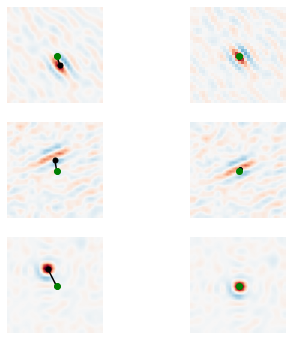

In [6]:
# plot to verify 
idx = np.random.randint(0, 250, 3) #164    

fig = plt.figure(figsize=(6, 6))
for i, j in enumerate(idx):
    ax = fig.add_subplot(3, 2, 2 * (i + 1) - 1)
    img = STA[j].reshape(32, 32)
    com = ndimage.measurements.center_of_mass(np.abs(img) ** 3)
    plt.imshow(img, cmap='RdBu')
    plt.plot([com[1], 16], [com[0], 16], 'k-o', markersize=5)
    plt.plot(16, 16, 'og')
    plt.clim(-10, 10)
    plt.axis('off')

    ax = fig.add_subplot(3, 2, 2 * (i + 1))
    img = centered_STA[j].reshape(32, 32)
    com = ndimage.measurements.center_of_mass(np.abs(img) ** 3)
    plt.imshow(img, cmap='RdBu')
    plt.plot([com[1], 16], [com[0], 16], 'ko', markersize=4)
    plt.plot(16, 16, 'og')
    plt.clim(-10, 10)
    plt.axis('off')
# plt.savefig('results/ringach_data/center_receptive_fields.pdf')

# print average center of mass of centered images
com_list = []
for img in centered_STA:
    img = img.reshape(32, 32)
    com = np.array(ndimage.measurements.center_of_mass(np.abs(img) ** 3))
    com_list.append(com)
com_list = np.array(com_list)
print('Mean com:', np.mean(com_list, axis=0), 'std com:', np.std(com_list, axis=0))

Generate covariance matrices from centered RFs

In [7]:
from estimator import V1_inspired_kernel_matrix
# covariance matrices
C_data = centered_STA.T @ centered_STA
C_data *= dim / np.trace(C_data).reshape(-1, 1)

# generate receptive field from our random feature model using finite number of cells
W = V1_inspired_weights_same_center(num_cells, dim, t=2,l=1.5, m=(16, 16), scale=1, random_state=22)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)
C_model_finite_sample = W.T @ W
C_model_finite_sample *= dim / np.trace(C_model_finite_sample).reshape(-1, 1)

# full covariance function
C_model = V1_inspired_kernel_matrix(dim, t=2, l=1.5, m=(16, 16), scale=1)
# C_model *= dim / np.trace(C_model).reshape(-1, 1)

# spectra analyses
eigval_data, eigvec_data = la.eigh(C_data)
eigval_model, eigvec_model = la.eigh(C_model)
eigval_model_finite_sample, eigvec_model_finite_sample = la.eigh(C_model_finite_sample)

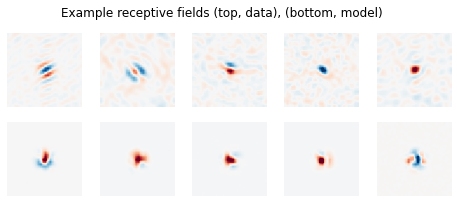

In [8]:
# plot a few receptive fields
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Example receptive fields (top, data), (bottom, model)', y=1)
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(num_cells)
    plt.imshow(centered_STA[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
#     plt.colorbar()
    

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.imshow(W[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
#     plt.colorbar()
# plt.savefig('results/ringach_data/receptive_fields_centered.pdf')

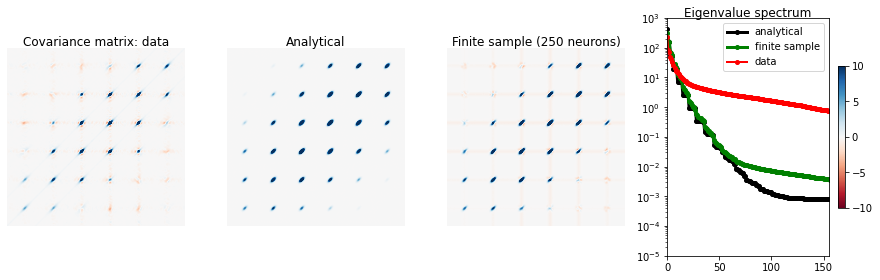

In [9]:
## Here positive values are much larger than negative values. 
## Adjust the color map accordingly. Set a wide range if centering colormap.
clim = 10
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(141)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
plt.clim(-clim, clim)
plt.xlim(412, 612)
plt.ylim(412, 612)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(142)
plt.title('Analytical', y=0.98)
plt.imshow(C_model, cmap='RdBu')
plt.clim(-clim, clim)
plt.xlim(412, 612)
plt.ylim(412, 612)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(143)
plt.title('Finite sample (250 neurons)', y=0.98)
plt.imshow(C_model_finite_sample, cmap='RdBu')
plt.clim(-clim, clim)
plt.xlim(412, 612)
plt.ylim(412, 612)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(144)
plt.title('Eigenvalue spectrum', y=0.98)
plt.semilogy(np.flip(eigval_model), '-ok', lw=3, markersize=4, label='analytical')
plt.semilogy(np.flip(eigval_model_finite_sample), '-og', lw=3, markersize=4, label='finite sample')
plt.semilogy(np.flip(eigval_data), '-ro', lw=2, markersize=4, label='data')
plt.xlim(0, 155)
plt.ylim(1e-5, 1e3)
plt.legend()
plt.tight_layout()
plt.colorbar(fraction=0.04)
# plt.savefig('results/ringach_data/covariance_matrices_centered_data.pdf')

### Visualize covariance of everything with the origin

(-0.5, 31.5, 31.5, -0.5)

<Figure size 432x288 with 0 Axes>

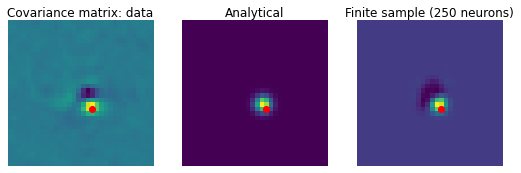

In [10]:
fig = plt.figure()

xdiff, ydiff = 2, 3
i = 528 + xdiff + ydiff * 32
C_data_row = C_data[i, :].reshape(32, 32)
C_model_row = C_model[i, :].reshape(32, 32)
C_model_finite_sample_row = C_model_finite_sample[i, :].reshape(32, 32)

fig = plt.figure
clim = 0.5
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(141)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data_row)
plt.plot(xdiff + 16, ydiff + 16, 'ro')
# plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(142)
plt.title('Analytical', y=0.98)
plt.imshow(C_model_row)
plt.plot(xdiff + 16, ydiff + 16, 'ro')
# plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(143)
plt.title('Finite sample (250 neurons)', y=0.98)
plt.imshow(C_model_finite_sample_row)
plt.plot(xdiff + 16, ydiff + 16, 'ro')
# plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

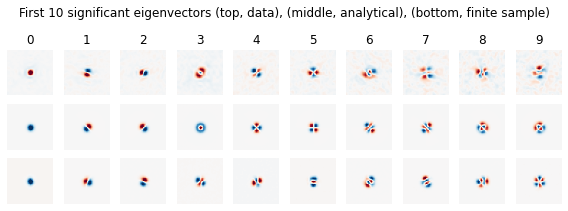

In [11]:
# plot the eigenvecs
fig = plt.figure(figsize=(8, 3))
plt.suptitle('First 10 significant eigenvectors (top, data), (middle, analytical), (bottom, finite sample)')
for i in range(10):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(i)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_data[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 10 + i +1)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 20 + i +1)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model_finite_sample[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.8)
# plt.savefig('results/ringach_data/cov_matrix_eigvecs_centered_data.pdf')

### Visualize average covariance as a function of distance from center

In [41]:
x = np.arange(32)
center = 16
yy, xx = np.meshgrid(x, x)
dist_from_center = np.sqrt((xx - center) ** 2 + (yy - center) ** 2).flatten()
yy, xx = np.meshgrid(dist_from_center, dist_from_center)

# divide into bins
nBins = 100
# bins = np.linspace(np.min(dist_from_center), np.max(dist_from_center), nBins)

In [42]:
# Histogram 
counts, xedges, yedges = np.histogram2d(xx.flatten(), yy.flatten(), bins=[nBins, nBins])
counts[counts == 0] = 1

# data
C_dist_data, _, _ = np.histogram2d(xx.flatten(), yy.flatten(), bins=[nBins, nBins], weights=C_data.flatten())
C_dist_data /= counts

# model
C_dist_model, _, _ = np.histogram2d(xx.flatten(), yy.flatten(), bins=[nBins, nBins], weights=C_model.flatten())
C_dist_model /= counts

# model finite sample
C_dist_model_finite_sample, _, _ = np.histogram2d(xx.flatten(), yy.flatten(), bins=[nBins, nBins], weights=C_model_finite_sample.flatten())
C_dist_model_finite_sample /= counts

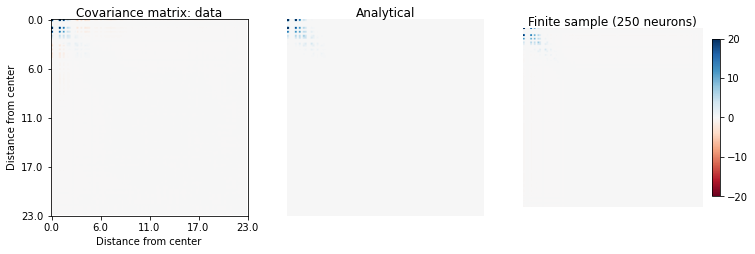

In [55]:
## Here positive values are much larger than negative values. Adjust the color map accordingly.
clim = 20
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(131)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_dist_data, cmap='RdBu')
tick_pos = np.linspace(0, nBins, 5)
tick_labels = np.round(np.linspace(0, np.max(dist_from_center), 5))
plt.xticks(tick_pos, tick_labels)
plt.yticks(tick_pos, tick_labels)
plt.xlabel('Distance from center')
plt.ylabel('Distance from center')
plt.clim(-clim, clim)
# plt.axis('off')

ax = fig.add_subplot(132)
plt.title('Analytical', y=0.98)
plt.imshow(C_dist_model, cmap='RdBu')
plt.clim(-clim, clim)
plt.axis('off')

ax = fig.add_subplot(133)
plt.title('Finite sample (250 neurons)', y=0.98)
plt.imshow(C_dist_model_finite_sample, cmap='RdBu')
plt.clim(-clim, clim)
plt.axis('off')
plt.colorbar(fraction=0.04)
# plt.savefig('results/ringach_data/cov_matrix_centered_data_dist_fitted.pdf')

### Fit covariance function to data to find optimal hyperparams

In [15]:
from scipy.optimize import minimize

def diff(x):
    cov_data = C_data.copy()
    cov_model = V1_inspired_kernel_matrix(dim, t=x[0], l=x[1], m=(16, 16), scale=1)
    return la.norm(cov_model - cov_data)

In [16]:
x0 = [2, 1.5]
min_diff = minimize(diff, x0, method='BFGS', tol=1e-4)
t_min, l_min = min_diff.x
print("Optimal params: size=%0.3f, freq=%0.3f" %(t_min, l_min))

Optimal params: size=2.411, freq=0.948


In [17]:
# generate receptive field from our random feature model using finite number of cells
W = V1_inspired_weights_same_center(num_cells, dim, t=t_min,l=l_min, m=(16, 16), scale=1, random_state=22)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)
C_model_finite_sample = W.T @ W
C_model_finite_sample *= dim / np.trace(C_model_finite_sample).reshape(-1, 1)

# full covariance function
C_model = V1_inspired_kernel_matrix(dim, t=t_min,l=l_min, m=(16, 16), scale=1)
C_model *= dim / np.trace(C_model).reshape(-1, 1)

# spectra analyses
eigval_data, eigvec_data = la.eigh(C_data)
eigval_model, eigvec_model = la.eigh(C_model)
eigval_model_finite_sample, eigvec_model_finite_sample = la.eigh(C_model_finite_sample) 

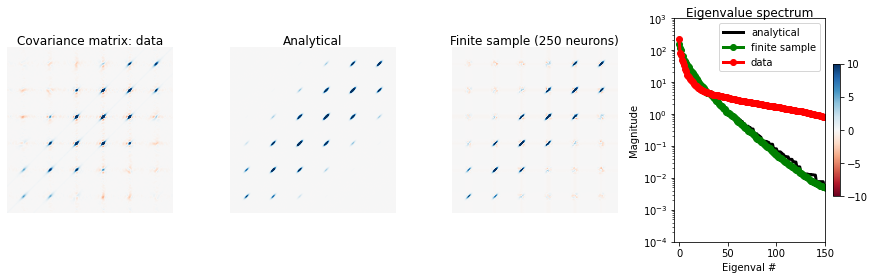

In [35]:
## Here positive values are much larger than negative values. 
## Adjust the color map accordingly. Set a wide range if centering colormap.
clim = 10
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(141)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
plt.clim(-clim, clim)
plt.xlim(412, 612)
plt.ylim(412, 612)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(142)
plt.title('Analytical', y=0.98)
plt.imshow(C_model, cmap='RdBu')
plt.clim(-clim, clim)
plt.xlim(412, 612)
plt.ylim(412, 612)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(143)
plt.title('Finite sample (250 neurons)', y=0.98)
plt.imshow(C_model_finite_sample, cmap='RdBu')
plt.clim(-clim, clim)
plt.xlim(412, 612)
plt.ylim(412, 612)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(144)
plt.title('Eigenvalue spectrum', y=0.98)
plt.semilogy(np.flip(eigval_model), 'k-', lw=3,label='analytical')
plt.semilogy(np.flip(eigval_model_finite_sample), '-go', lw=3,  label='finite sample')
plt.semilogy(np.flip(eigval_data), 'r-o', lw=3, label='data')
plt.xlabel('Eigenval #')
plt.ylabel('Magnitude')
plt.xlim(-5, 150)
plt.ylim(1e-4, 1e3)
plt.legend()
plt.tight_layout()
plt.colorbar(fraction=0.04)
plt.savefig('results/ringach_data/covariance_matrices_centered_data_fitted.pdf')

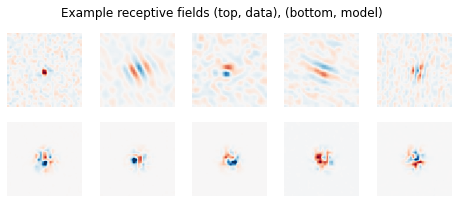

In [39]:
# plot a few receptive fields
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Example receptive fields (top, data), (bottom, model)', y=1)
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(num_cells)
    plt.imshow(centered_STA[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
#     plt.colorbar()
    

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.imshow(W[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
#     plt.colorbar()
plt.savefig('results/ringach_data/receptive_fields_centered_fitted.pdf')

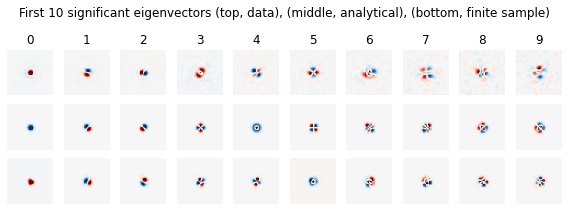

In [40]:
# plot the eigenvecs
fig = plt.figure(figsize=(8, 3))
plt.suptitle('First 10 significant eigenvectors (top, data), (middle, analytical), (bottom, finite sample)')
for i in range(10):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(i)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_data[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 10 + i +1)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 20 + i +1)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model_finite_sample[:, -i - 1].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig('results/ringach_data/eigvecs_cov_mat_fitted.pdf')

### Plot eigenfunctions of V1 kernel

\begin{align}
\hat{\phi}_k(t) &= \dfrac{2^k k! \sqrt{\pi}}{C} \cdot e^{-D t^2} \cdot H_k(Ct),  
\text{ where } D = \sqrt{\beta^2 + 2\alpha \beta},
 C = \sqrt{2 D}, \\
\text { where } \alpha &= \dfrac{1}{2f^2}, \beta = \dfrac{1}{2s^2} \\
\lambda_k &= \sqrt{\dfrac{\pi}{\alpha + \beta + D}} \left( 1 - \dfrac{C^2}{\alpha + \beta + D} \right)^{k/2}
\end{align}

In [178]:
from scipy.special import eval_hermitenorm
import numpy as np
import matplotlib.pyplot as plt

In [237]:
def phi(x, s, f, k):
    ''' Orthonormal eigenfunctions of the V1 kernel in 1d'''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    normalization_fac = 2 ** k * np.math.factorial(k) * np.sqrt(np.pi) / C
    return np.exp(- D * x ** 2) * eval_hermitenorm(k, C * x)

def lamda(s, f, k):
    ''' Eigenvalues of the V1 kernel in 1d '''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    X = alpha + beta + D
    return np.sqrt(np.pi / X) * ( 1 - C ** 2 / X) ** (k / 2)

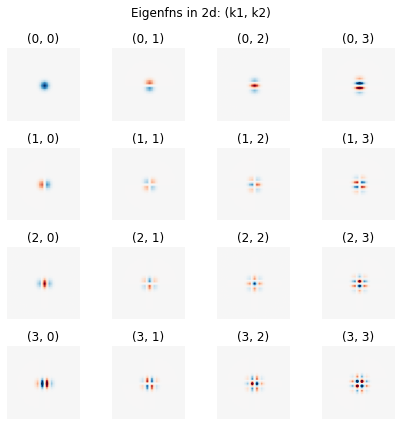

In [259]:
N = 1024
x = np.arange(-16, 16, 1)
yy, xx = np.meshgrid(x, x)

# params
s, f = 2.411, 0.948

# plot eigenfunctions
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(4, 4)
plt.suptitle('Eigenfns in 2d: (k1, k2)')
for k1 in range(4):
    for k2 in range(4):
        eigfn = phi(yy, s, f, k1) * phi(xx, s, f, k2)
        ax = fig.add_subplot(gs[k1, k2])
        plt.title((k1, k2))
        plt.imshow(eigfn, cmap='RdBu')
        plt.clim(-1, 1)
        plt.axis('off')
plt.tight_layout()

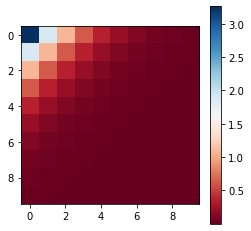

In [243]:
# plot eigvalues
k = np.arange(10)
k1, k2 = np.meshgrid(k, k)

# plot eigenfunctions
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
eigval = lamda(s, f, k1) * lamda(s, f, k2)
plt.imshow(eigval, cmap='RdBu')
# plt.clim(-0.5, 0.5)
plt.colorbar()

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])